In [3]:
import numpy as np 
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import warnings
warnings.simplefilter("ignore")
import yfinance as yf

from plotly.subplots import make_subplots

from ta.trend import MACD
from ta.momentum import StochasticOscillator
import pandas_ta as ta
import os


# Plotting Exponential Moving Averages on NATCOPHARM
A EMA allows you to see the big picture when analyzing a stock. Unlike the Simple Moving Average it reduces the lag by putting more emphasis on recent price data.

YF.download() has changed argument auto_adjust default to True


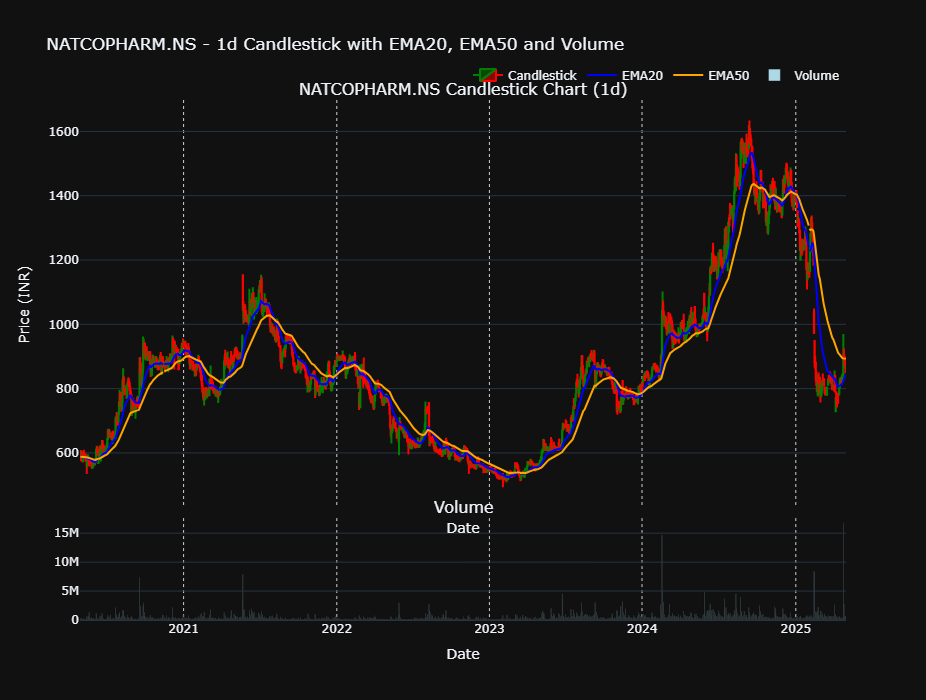

In [6]:
# Path where CSVs will be saved
PATH = r"C:\Users\91909\Desktop\Stock_Data"

# Download and save stock data with EMA columns
def save_to_csv_from_yahoo(ticker: str, interval: str = "1d") -> bool:
    df = yf.download(ticker, period="5y", interval=interval, progress=False)
    
    # Calculate EMAs
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

    os.makedirs(PATH, exist_ok=True)
    fn = os.path.join(PATH, f"{ticker}_{interval}.csv")
    df.to_csv(fn)
    return True

# Load stock data from saved CSV
def get_stock_df_from_csv(ticker: str, interval: str = "1d") -> pd.DataFrame:
    fn = os.path.join(PATH, f"{ticker}_{interval}.csv")
    df = pd.read_csv(fn, index_col=0, parse_dates=True)
    
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df

# Plot candlestick chart with EMAs and volume
def plot_candlestick_with_volume(ticker: str, interval: str = "1d"):
    save_to_csv_from_yahoo(ticker, interval)
    df = get_stock_df_from_csv(ticker, interval)

    # Create subplots (Candlestick + Volume)
    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02,
        row_width=[0.2, 0.8],
        subplot_titles=(f"{ticker} Candlestick Chart ({interval})", "Volume")
    )

    # Candlestick chart
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df["Open"], high=df["High"],
            low=df["Low"], close=df["Close"],
            name="Candlestick",
            increasing_line_color='green',
            decreasing_line_color='red'
        ),
        row=1, col=1
    )

    # EMA 20
    fig.add_trace(
        go.Scatter(
            x=df.index, y=df['EMA_20'],
            line=dict(color='blue', width=2),
            name='EMA20'
        ),
        row=1, col=1
    )

    # EMA 50
    fig.add_trace(
        go.Scatter(
            x=df.index, y=df['EMA_50'],
            line=dict(color='orange', width=2),
            name='EMA50'
        ),
        row=1, col=1
    )

    # Volume bar chart
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df['Volume'],
            name='Volume',
            marker_color='lightblue'
        ),
        row=2, col=1
    )

    fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[dict(bounds=["sat", "mon"])],
        type="date",
        showgrid=True,
        gridcolor='lightgrey',
        griddash='dot',
        title_text='Date'
    )

    fig.update_layout(
        title=f'{ticker} - {interval} Candlestick with EMA20, EMA50 and Volume',
        yaxis_title='Price (INR)',
        template='plotly_dark',
        width=1100,
        height=700,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        hovermode='x unified'
    )

    fig.show()

# Example usage
plot_candlestick_with_volume("NATCOPHARM.NS", interval="1d")

# Moving Average Convergence & Divergence
The MACD helps us to see buy & sell signals. It shows the difference between 2 moving averages.

While these signals are derived from moving averages they occur much more quickly then with moving averages. It is important to know that since the signals occur earlier that they are also more risky.

When the signal line crosses the MACD line moving upwards this is bullish and vice versa. The slope of the angle tells you how strong the trend is.

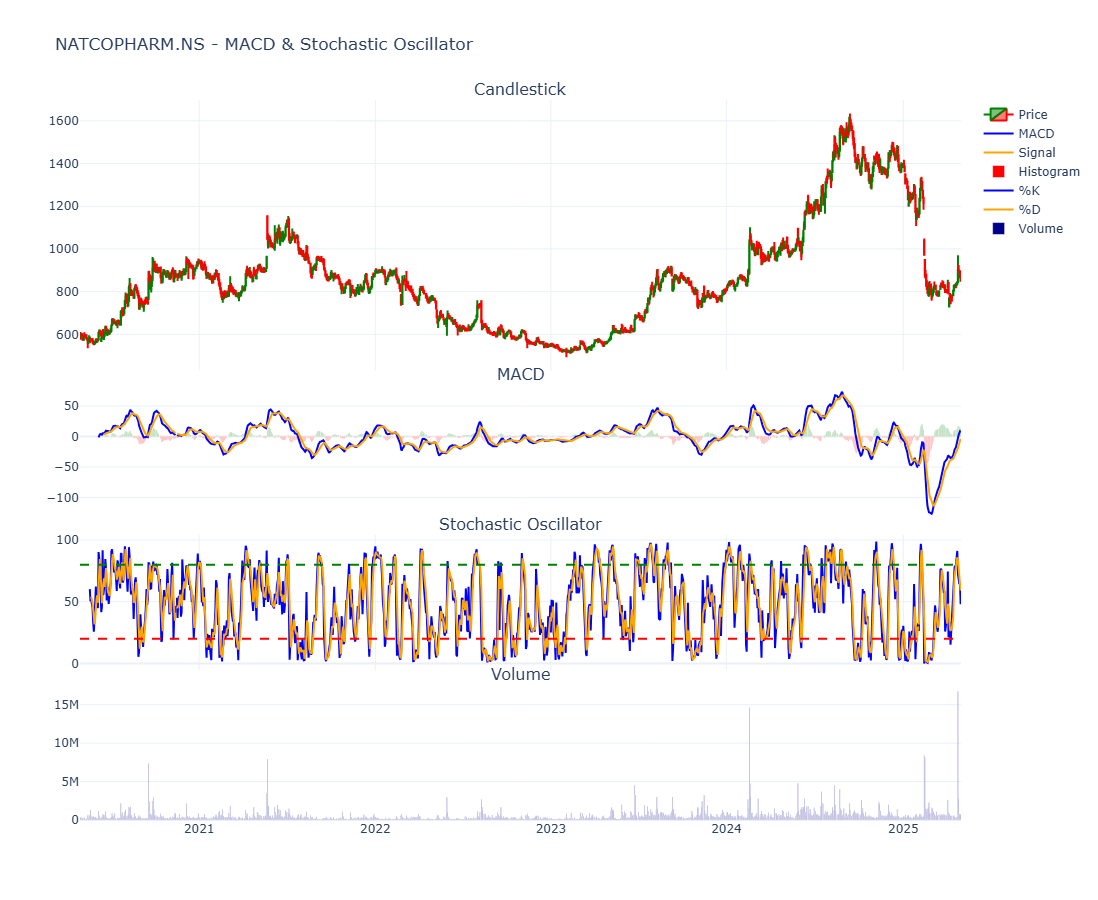

In [52]:
DATA_PATH = r"C:\Users\91909\Desktop\Stock_Data"

def download_data(ticker: str, interval: str = "1d") -> pd.DataFrame:
    os.makedirs(DATA_PATH, exist_ok=True)
    filepath = os.path.join(DATA_PATH, f"{ticker}_{interval}.csv")
    df = yf.download(ticker, period="5y", interval=interval)
    if df.empty:
        print("No data found.")
        return pd.DataFrame()
    df.to_csv(filepath)
    return df

def load_data(ticker: str, interval: str = "1d") -> pd.DataFrame:
    filepath = os.path.join(DATA_PATH, f"{ticker}_{interval}.csv")
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
    except Exception:
        df = download_data(ticker, interval)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

    # 🔧 Fix: Convert to numeric to avoid MACD calculation errors
    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    return df

def plot_macd_stochastic(ticker: str, interval: str = "1d"):
    df = load_data(ticker, interval)
    if df.empty:
        print("No valid data to plot.")
        return

    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])

    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                        row_heights=[0.4, 0.2, 0.2, 0.2],
                        subplot_titles=("Candlestick", "MACD", "Stochastic Oscillator", "Volume"))

    fig.add_trace(go.Candlestick(x=df.index, open=df['Open'], high=df['High'],
                                 low=df['Low'], close=df['Close'], name="Price",
                                 increasing_line_color='green', decreasing_line_color='red'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=macd.macd(), name="MACD", line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=macd.macd_signal(), name="Signal", line=dict(color='orange')), row=2, col=1)
    colors = ['green' if val >= 0 else 'red' for val in macd.macd_diff()]
    fig.add_trace(go.Bar(x=df.index, y=macd.macd_diff(), name="Histogram", marker_color=colors), row=2, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=stoch.stoch(), name="%K", line=dict(color='blue')), row=3, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=stoch.stoch_signal(), name="%D", line=dict(color='orange')), row=3, col=1)
    fig.add_hline(y=80, line_color="green", line_dash="dash", row=3, col=1)
    fig.add_hline(y=20, line_color="red", line_dash="dash", row=3, col=1)

    fig.add_trace(go.Bar(x=df.index, y=df['Volume'], name="Volume", marker_color='DARKblue'), row=4, col=1)

    fig.update_layout(
        title=f"{ticker} - MACD & Stochastic Oscillator",
        template="plotly_white",
        height=900,
        width=1100,
        showlegend=True,
        xaxis_rangeslider_visible=False,
        hovermode="x unified",
    )
    # fig.update_xaxes(title="Date", rangeslider_visible=True)
    fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])
    fig.show()

plot_macd_stochastic("NATCOPHARM.NS")


In [56]:
# If we plot NATCOPHARM.NS we can see a resistance line at around 140 on multiple dates
# The volumes spike leading into uptrends
# plot_macd_stoch("PG", "2mo", "1h")

# Now we will zoom in and we can see how when the MACD crosses over that these are potential 
# opportunities to buy or sell (This example would work better if we were near 140)

# A Stochastic (stuh ka stuhk) Oscillator is also plotted because it 
# gives us a signal of an upcoming trend reversal
# Values range from 0 to 100 and values over 80 are considered to be
# overbought while those under 20 are considered oversold
# This isn't a simple buy or sell plot however and it is common for stocks
# to stay overbought or sold over long periods
# This isn't a chart you use on its own, but instead to backup other charts
# You use it normally when an investment is either in a down or up trend.
# This means the stock is bouncing up and down, but consistently reaching higher highs
# or lower lows. When in one of these trends it is common for it to remain in
# overbought or sold trends for a long time.

# Don't buy based on this chart during downtrends and don't sell during uptrends!